In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
diccionario_tipos = {
    "tipodepropiedad":"category",
    "provincia":"category",
    "provincia":"category",
    #"habitaciones":"int",
    #"garages":"int",
    #"banos":"int",
    #'metroscubiertos':, 'metrostotales', 'idzona', 'lat', 'lng',
    'gimnasio':"bool",
    'usosmultiples':"bool",
    'piscina':"bool",
    'escuelascercanas':"bool",
    'centroscomercialescercanos':"bool"
}
df = pd.read_csv("data/train.csv", dtype = diccionario_tipos)

In [3]:
df[["metrostotales", "metroscubiertos"]].isnull().agg(sum)

metrostotales      51467
metroscubiertos    17400
dtype: int64

In [4]:
 df[["metrostotales", "metroscubiertos"]].isnull().agg(sum) / df.shape[0]

metrostotales      0.214446
metroscubiertos    0.072500
dtype: float64

Podemos ver como las columnas "Metros totales" y "Metros cubiertos" tienen una gran cantidad de nulos, principalmente "Metros totales" que tiene un 21% de nulos.

In [5]:
df.loc[(df["metrostotales"] == 0) | (df["metroscubiertos"] == 0)].shape

(0, 23)

In [6]:
df.loc[(df["metrostotales"].isnull()) & (df["metroscubiertos"].isnull())].shape

(0, 23)

Por otro lado, estas columnas tienen dos particularidades:
 - No hay **ninguna** entrada que tenga los **dos** campos como nulos al mismo tiempo.
 - En ningún caso tienen como valor **0**.
 
Es decir, no hay ninguna propiedad que tenga las dos caracterísitcas incompletas sin embargo hay gran cantidad de nulos en ambas categorías por separado.

Veamos cual es la relacion entre que datos tiene cada propiedad

In [7]:
df["tiene_los_dos"] = df["metrostotales"].notnull() & df["metroscubiertos"].notnull()
df["tiene_los_dos"].value_counts()

True     171133
False     68867
Name: tiene_los_dos, dtype: int64

In [8]:
propiedades_con_metros= df.loc[df["tiene_los_dos"] == True].copy()
propiedades_con_metros["metros_descubiertos"] = propiedades_con_metros["metrostotales"] - propiedades_con_metros["metroscubiertos"]
propiedades_con_metros["metros_descubiertos"].value_counts().head()

 0.0     37884
 20.0     2583
 10.0     2482
-20.0     2333
-30.0     2098
Name: metros_descubiertos, dtype: int64

Text(0,0.5,'Cantidad de propiedades')

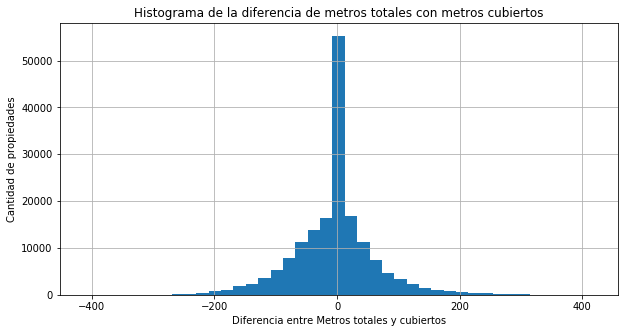

In [9]:
fig = plt.figure(figsize = (10,5))
g = propiedades_con_metros["metros_descubiertos"].hist(bins=41)
plt.title("Histograma de la diferencia de metros totales con metros cubiertos")
g.set_xlabel("Diferencia entre Metros totales y cubiertos")
g.set_ylabel("Cantidad de propiedades")

In [10]:
print("Proporción de propiedades con MAS metros cubiertos que totales: ", \
      (df.loc[df["metrostotales"] < df["metroscubiertos"]].copy().shape[0]) / df.shape[0])


Proporción de propiedades con MAS metros cubiertos que totales:  0.29289583333333336


Descubrimos que a un 29% de las propiedades tienen una cantidad de metros cubiertos mayor a la de metros totales. Pero haciendo un histograma de la diferencia entre estos dos valores podemos ver que es muy simétrico. 
Dado que sabemos que para ninguno de estos casos los valores son nulos. Deducimos que es muy probable que haya datos ingresados al revez. Es decir, que se ingresó en metros cubiertos el valor que debería estar en metros totales y viceversa.

Text(0,0.5,'Proporcion')

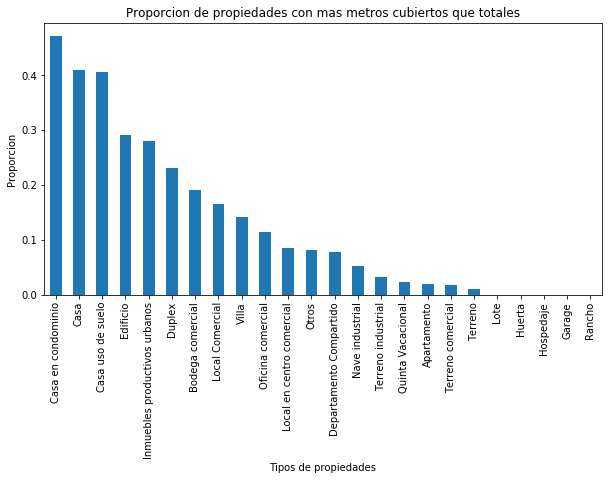

In [11]:
fig = plt.figure(figsize = (10,5))
cantidad_de_tipos_propiedades = df["tipodepropiedad"].value_counts()
cantidad_de_tipos_propiedades_negativos = df.loc[df["metrostotales"] < df["metroscubiertos"], "tipodepropiedad"].copy().value_counts()
proporcion = cantidad_de_tipos_propiedades_negativos / cantidad_de_tipos_propiedades
g = proporcion.sort_values(ascending=False).plot(kind="bar")
plt.title("Proporcion de propiedades con mas metros cubiertos que totales")
g.set_xlabel("Tipos de propiedades")
g.set_ylabel("Proporcion")

Podemos ver como este fenomeno se produce mas en propiedades que es mas común que tengan un poco de terreno descubierto (casas por ejemplo), en propiedades que pueden llegar a tener metros compartidos (edificios con patio común) o propiedades que puedan tener mas de una planta (duplex). Todos estas características suman a la posibilidad de que los datos estén cargados de forma errónea.

#### Vamos a intercambiar los valores de metros totales y cubieros para aquellas propiedades que tienen mas metrs cubiertos que totales

In [17]:
def swap_selectivo(fil):
    if fil["metrostotales"] < fil["metroscubiertos"]:
        aux = fil["metrostotales"]
        fil["metrostotales"] = fil["metroscubiertos"]
        fil["metroscubiertos"] = fil["metrostotales"]
    return fil
"""
df_con_estilo = df.apply( swap_selectivo, axis=1).copy()
df_con_estilo["metrostotales"] - df_con_estilo["metroscubiertos"]"""
df["swapear"] = df["metrostotales"] < df["metroscubiertos"]

aux = df.loc[df["swapear"], "metrostotales"].copy()
if (not aux.empty):
    df.loc[df["swapear"],"metrostotales"] = df.loc[df["swapear"], "metroscubiertos"]
    df["metroscubiertos"] = aux
df.drop(columns="swapear", inplace=True)
(df["metrostotales"] < df["metroscubiertos"]).value_counts()
df[["metrostotales", "metroscubiertos"]]

AttributeError: 'DataFrame' object has no attribute 'value_counts'

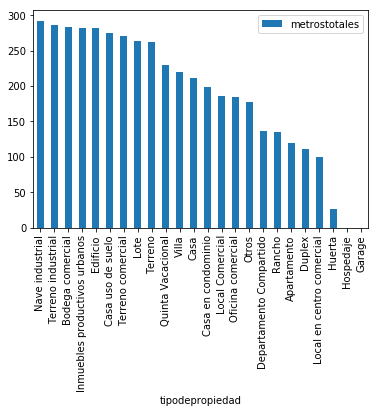

In [19]:
df.groupby("tipodepropiedad").agg({"metrostotales":"mean"}).sort_values(by="metrostotales", ascending = False).plot(kind = "bar")


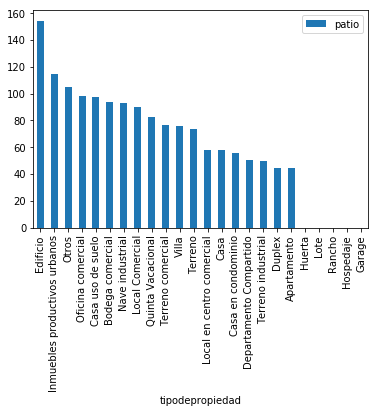

In [20]:
df["patio"] = df["metrostotales"] - df["metroscubiertos"]
df.groupby("tipodepropiedad").agg({"patio":"mean"}).sort_values(by="patio", ascending = False).plot(kind = "bar")

In [15]:
prop_cubiertas = b.loc[b["metros_descubiertos"] == 0]
prop_cubiertas["tipodepropiedad"].value_counts()

NameError: name 'b' is not defined

#### Alanizamos como afectan los metros al precio